In [55]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import numpy as np

df = pd.read_csv("train.csv")
df = df.dropna()
df['bid_ask_ratio'] = df['bid_size']/df['ask_size']
features_df = df[['ask_size', 'imbalance_size', 'matched_size', 'bid_size','bid_ask_ratio']]
target_df = df['reference_price']

X = features_df.values
y = target_df.values

scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [57]:

class ImprovedLinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ImprovedLinearModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))  
        x = self.fc2(x)
        return x

input_dim = 5
hidden_dim = 5  
output_dim = 1

model = ImprovedLinearModel(input_dim, hidden_dim, output_dim)
loss_function = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Consider adjusting learning rate if NaN persists


In [58]:

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train)
    loss = loss_function(predictions, y_train)
    if torch.isnan(loss):
        print(f"NaN loss detected at epoch {epoch}")
        break 
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:  
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = loss_function(predictions, y_test)
    print(f'Test Loss: {test_loss.item()}')


Epoch 1/100, Loss: 1.2240148782730103
Epoch 11/100, Loss: 1.195258617401123
Epoch 21/100, Loss: 1.1693696975708008
Epoch 31/100, Loss: 1.1463794708251953
Epoch 41/100, Loss: 1.1261730194091797
Epoch 51/100, Loss: 1.1085125207901
Epoch 61/100, Loss: 1.0931110382080078
Epoch 71/100, Loss: 1.0796948671340942
Epoch 81/100, Loss: 1.0680224895477295
Epoch 91/100, Loss: 1.057877779006958
Test Loss: 1.049373984336853


Mean Absolute Error (MAE): 0.002225654199719429
Root Mean Squared Error (RMSE): 0.0030642845667898655
R-squared (R^2): -0.04665425877453555


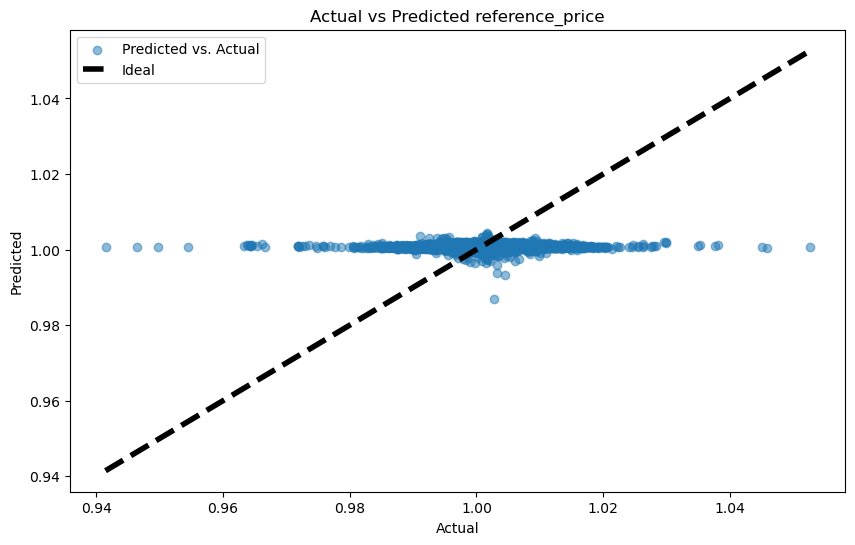

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model.eval()
with torch.no_grad():
    predictions_scaled = model(X_test).numpy()  # Predictions in the scaled domain
    predictions = scaler_y.inverse_transform(predictions_scaled)  # Convert predictions back to original scale
    actual_values = scaler_y.inverse_transform(y_test.numpy())  # Convert actual values back to original scale

mae = mean_absolute_error(actual_values, predictions)
rmse = mean_squared_error(actual_values, predictions, squared=False)
r2 = r2_score(actual_values, predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R^2): {r2}')

plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predictions, alpha=0.5, label="Predicted vs. Actual")
plt.plot([actual_values.min(), actual_values.max()], [actual_values.min(), actual_values.max()], 'k--', lw=4, label="Ideal")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted reference_price')
plt.legend()
plt.show()


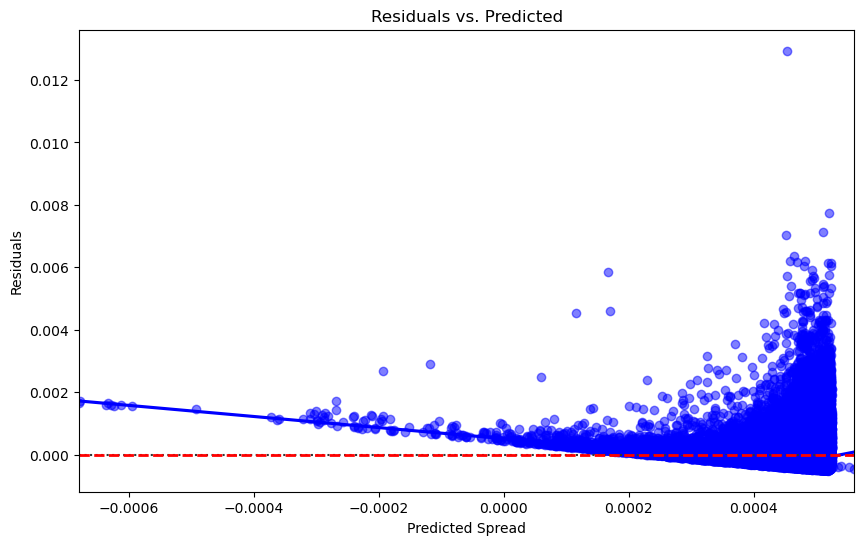

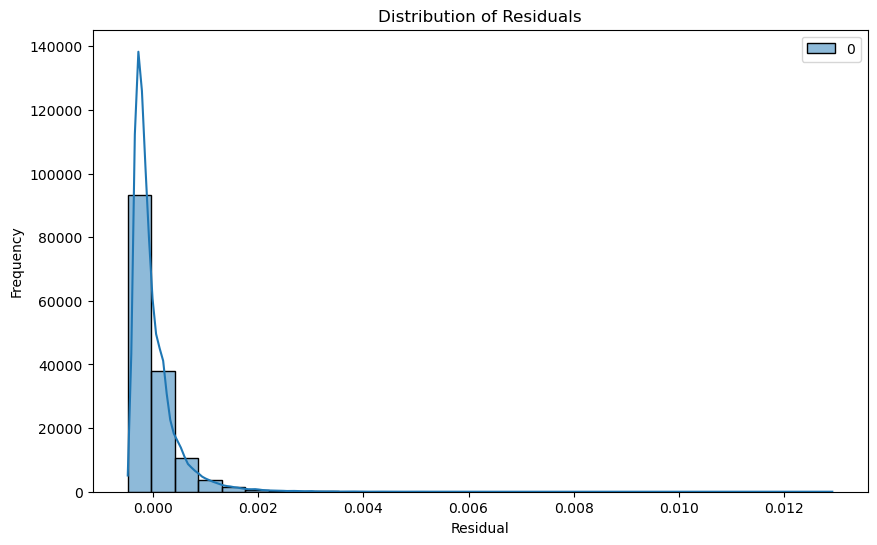